# Evaluation of Graph Neural Network segment classifier

In [23]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [1]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [3]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/ExaTrkX/doublet_results')

In [4]:
ls $result_base

agnn01/  agnn02/  agnn03/  checkpoints_med_000/  checkpoints_tiny_000/


In [5]:
result_name = 'agnn03'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/doublet_data/hitgraphs_med_000',
          'n_train': 2000,
          'n_valid': 20,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 4,
           'name': 'agnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 45,
                                      'factor': 0.1,
                                      'start_epoch': 15},
                                     {'end_epoch': 64,
                                      'factor': 0.01,
                                      'start_epoch': 45}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 'output_dir': 

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.586104,2771.204409,110.572367,0,28.486812,0.592492,0.633848,0.564587
1,0.00100,0.583811,2858.860913,113.467192,1,27.793196,0.622164,0.673413,0.330643
2,0.00100,0.449013,2944.654240,116.943453,2,28.065021,0.325593,0.841056,0.339804
3,0.00100,0.341559,3010.028200,119.350692,3,28.650597,0.251842,0.883964,0.359094
4,0.00100,0.263951,3053.289420,121.042928,4,28.345083,0.318955,0.843807,0.330041
5,0.00100,0.293824,3086.119387,122.209467,5,28.175375,0.213713,0.906025,0.336945
6,0.00100,0.163868,3102.160514,122.722735,6,28.431455,0.149721,0.932066,0.353332
7,0.00100,0.162029,3126.568887,123.479624,7,28.524186,0.214245,0.901042,0.333970
8,0.00100,0.152849,3144.707661,124.143374,8,28.594389,0.162813,0.925556,0.341059
9,0.00100,0.179155,3173.045781,125.142804,9,28.562701,0.128173,0.933646,0.339416


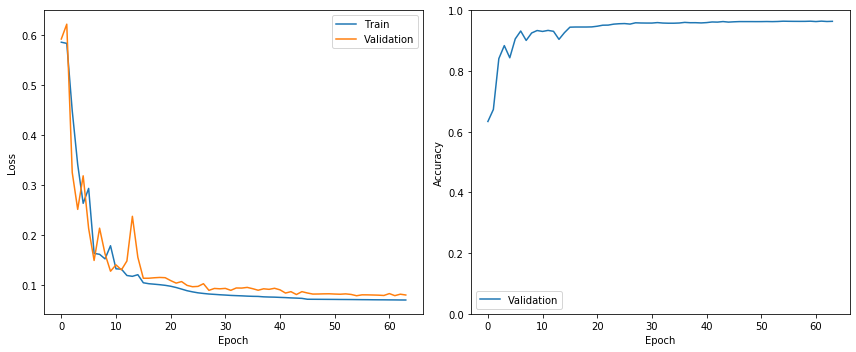

In [6]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

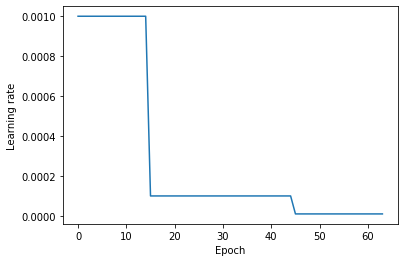

In [7]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [8]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
54,0.00001,0.071438,3279.973925,129.673661,54,28.846646,0.079155,0.964403,0.345899


In [9]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

## Evaluate the model on the test dataset

In [10]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [13]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 2min 42s, sys: 3.4 s, total: 2min 46s
Wall time: 42.4 s


In [14]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9655
Precision: 0.8634
Recall:    0.9852


In [39]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9742
Precision: 0.9293
Recall:    0.9445


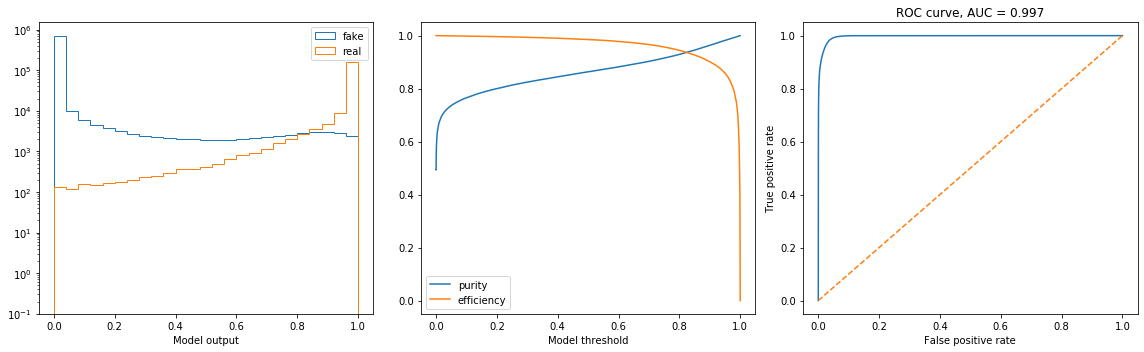

In [15]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [16]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [2]:
draw_sample_xy(x, e, o, y, cut=0.9);

NameError: name 'x' is not defined